# Statistical study

## Table of content

* [Data reduction](#Data-reduction)
* [Comparison plots](#Plots)
* [Statistics](#Statistics)
* [Machine learning tests](#Machine-learning-tests)

## Data reduction

In [1]:
from __future__ import print_function

%matplotlib inline

import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
from scipy import stats

sb.set(font_scale=2)

/usr/local/lib/python2.7/site-packages/matplotlib/__init__.py:878: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
data = pd.read_csv("../catalogs/matched/galsvm-ngcas-asterism-cuts_20160628.csv")
data['morph_conc_ic'] = data.morph_conc_2_ic

## Parameters of interest

In [3]:
params_galsvm = [
    'CABR',
    'ASYM',
    'SMOOTH',
    'GINI',
    'M20'
]

params_ngcas = [
    'C',
    'A',
    'S',
    'Gini',
    'M_20'
]

params_asterism = [
    'morph_conc_ic',
    'morph_asymm_ic',
    'morph_clumpiness_ic',
    'morph_Gini_ic',
    'morph_M20_ic'
]

params = params_galsvm + params_ngcas
allparams = params_galsvm + params_ngcas + params_asterism

dict_lims = dict(
    CABR=[0, 1],
    c=[1, 5],
    ASYM=[0, 0.5],
    SMOOTH=[0, 0.1],
    GINI=[0, 1],
    M20=[-3 ,0],
    C=[1, 5],
    A=[0, 0.5],
    S=[0, 0.1],
    Gini=[0, 1],
    M_20=[-3, 0],
    #morph_conc_ic=[1, 5],
    morph_conc_ic=[0, 1],
    morph_asymm_ic=[0, 0.5],
    #morph_clumpiness_ic=[0, 12],
    morph_clumpiness_ic=[0, 8],
    morph_Gini_ic=[0, 1],
    morph_M20_ic=[-3, 0])

dict_title = dict(
    CABR="Concentration Abraham galSVM",
    c="Concentration galSVM",
    ASYM='Asymmetry galSVM',
    SMOOTH='Smoothness galSVM',
    GINI='Gini galSVM',
    M20=r'$M_{20}$ galSVM',
    C="Concentration ngCAS",
    A='Asymmetry ngCAS',
    S='Smoothness ngCAS',
    Gini='Gini ngCAS',
    M_20=r'$M_{20}$ ngCAS',
    morph_conc_ic="Concentration ASTErIsM",
    morph_asymm_ic='Asymmetry ASTErIsM',
    morph_clumpiness_ic='Clumpiness ASTErIsM',
    morph_Gini_ic='Gini ASTErIsM',
    morph_M20_ic=r'$M_{20}$ ASTErIsM')

params_plot = ['CABR', 'C', 
               'ASYM', 'A', 
               'SMOOTH', 'S', 
               'GINI', 'Gini', 
               'M20', 'M_20']

allparams_plot = ['CABR', 'C',  'morph_conc_ic', 
                  'ASYM', 'A', 'morph_asymm_ic', 
                  'SMOOTH', 'S', 'morph_clumpiness_ic', 
                  'GINI', 'Gini', 'morph_Gini_ic', 
                  'M20', 'M_20', 'morph_M20_ic']

params_galsvm_nn = [p + "_nn" for p in params_galsvm]
params_ngcas_nn = [p + "_nn" for p in params_ngcas]
params_nn = params_galsvm_nn + params_ngcas_nn

params_plot_nn = [p + "_nn" for p in params_plot]

## Check for outliers

### With noisy image

In [4]:
for p in params_galsvm:
    print(dict_title[p], (data[p] == 99.9).sum(), sep='\t')

Concentration Abraham galSVM	0
Asymmetry galSVM	0
Smoothness galSVM	0
Gini galSVM	0
$M_{20}$ galSVM	101


In [5]:
for idx, p in enumerate(params_ngcas):
    print(dict_title[p] , (data[p] == 0.0).sum(), sep='\t')

Concentration ngCAS	0
Asymmetry ngCAS	15
Smoothness ngCAS	1300
Gini ngCAS	0
$M_{20}$ ngCAS	165


In [6]:
for idx, p in enumerate(params_asterism):
    print(dict_title[p] , (data[p] == -100).sum(), sep='\t')

Concentration ASTErIsM	0
Asymmetry ASTErIsM	0
Clumpiness ASTErIsM	0
Gini ASTErIsM	0
$M_{20}$ ASTErIsM	0


## Remove outliers

In [7]:
# galSVM outliers are set to 99.9 by default
data = data.replace(99.9, np.nan)

In [8]:
# NGCAS outliers are set to -100 to be later set to NaNs
mask_casa = data.A < -0.5
data['A'] = data['A'] * ~mask_casa + mask_casa * -100
mask_gini1 = data.Gini > 2
data['Gini'] = data['Gini'] * ~mask_gini1 + mask_gini1 * -100
mask_gini2 = data.Gini < -1
data['Gini'] = data['Gini'] * ~mask_gini2 + mask_gini2 * -100
mask_m20 = data.M_20 < -4
data['M_20'] = data['M_20'] * ~mask_m20 + mask_m20 * -100

In [9]:
# ASTErIsM outliers are set to -100
data = data.replace(-100, np.nan)

## Selection criteria

### B/T

In [10]:
early_type = (data.bt > 0.5)
late_type = (data.bt <= 0.5)
print("Number of early type galaxies : %d and late type ones : %d" % (early_type.sum(), late_type.sum()))

Number of early type galaxies : 220 and late type ones : 1345


In [11]:
data['B/T<0.5'] = late_type

### Purity + B/T

In [12]:
pure_early_type = data['cut_10-mag_3'] & early_type
pure_late_type = data['cut_10-mag_3'] & late_type
print("Number of lonely early type galaxies : %d and late type ones : %d" % (pure_early_type.sum(), pure_late_type.sum()))

Number of lonely early type galaxies : 144 and late type ones : 987


### Input radius

In [13]:
mask_radius = data.disk_radius > data.bulge_radius
alpha = 0.8 * mask_radius + 2 * ~mask_radius
data['radius'] = data.disk_radius * (1 - data.bt)**alpha + data.bulge_radius * data.bt**alpha

### Radius cuts w.r.t FWHM

In [14]:
FWHM = 0.2  # in arcseconds
factor = 2

low = data.radius <= FWHM
mid = (data.radius > FWHM) & (data.radius <= factor * FWHM)
high = data.radius > factor * FWHM

data['fwhm'] = 0 * low + 1 * mid + 2 * high

### Magnitude

In [15]:
low = data.mag <= 22
mid = (data.mag > 22) & (data.mag <= 23)
high = data.mag > 23
# print(data.mag[low].mean(), data.mag[mid].mean(), data.mag[high].mean())
data['magcut'] = 21 * low + 22.5 * mid + 23.5 * high

## Plots

### Double histogram w.r.t B/T

In [40]:
def plot_histograms_bt_list(parameters, cuts, bins=30, suffix=''):
    cut1, cut2 = cuts
    plot_kws = dict(rug=False, axlabel=False, kde=False, norm_hist=True)
    
    fig, axes = plt.subplots(5, 2, figsize=(16, 30))
    for idx, ax in enumerate(axes.flat):
        param = parameters[idx]
        sb.distplot(data[param][cut1].dropna(), ax=ax, label='B/T > 0.5', **plot_kws)
        sb.distplot(data[param][cut2].dropna(), ax=ax, label='B/T < 0.5', **plot_kws)
#         ax.hist(datann[param][cut1], range=dict_lims[param], bins=bins, alpha=0.8, normed=True, label='B/T > 0.5')
#         ax.hist(datann[param][cut2], range=dict_lims[param], bins=bins, alpha=0.5, normed=True, label='B/T < 0.5')
        ax.set_xlabel(dict_title[params_plot[idx]])
        ax.set_xlim(dict_lims[params_plot[idx]])
        plt.setp(ax, yticks=[])
        if idx % 2:
            ax.legend(loc='best')
    fig.tight_layout()
    if suffix:
        fig.savefig('Morpho_vs_bt%s.png' % suffix)

### Triple histogram w.r.t B/T

In [48]:
def plot_triple_histograms_bt_list(parameters, cuts, bins=30, suffix=''):
    cut1, cut2 = cuts
    plot_kws = dict(rug=False, axlabel=False, kde=False, norm_hist=True)
    
    fig, axes = plt.subplots(5, 3, figsize=(20, 25))
    for idx, ax in enumerate(axes.flat):
        param = parameters[idx]
        sb.distplot(data[param][cut1].dropna(), ax=ax, label='B/T > 0.5', **plot_kws)
        sb.distplot(data[param][cut2].dropna(), ax=ax, label='B/T < 0.5', **plot_kws)
#       # ax.hist(datann[param][cut1], range=dict_lims[param], bins=bins, alpha=0.8, normed=True, label='B/T > 0.5')
#       # ax.hist(datann[param][cut2], range=dict_lims[param], bins=bins, alpha=0.5, normed=True, label='B/T < 0.5')
        ax.set_xlabel(dict_title[allparams_plot[idx]])
        ax.set_xlim(dict_lims[allparams_plot[idx]])
        plt.setp(ax, yticks=[])
        if idx % 3 == 2:
            ax.legend(loc='best')
    fig.tight_layout()
    if suffix:
        fig.savefig('all_morpho_vs_bt%s.png' % suffix)

In [69]:
def plot_histograms_list(param, bins=30, suffix=''):
    cut = data['cut_10-mag_3']
    plot_kws = dict(rug=False, axlabel=False, kde=False, norm_hist=True)
    
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    sb.distplot(data[param[0]].dropna(), ax=ax[0], label='galSVM', **plot_kws)
    sb.distplot(data[param[1]].dropna(), ax=ax[0], label='ngCAS', **plot_kws)
    sb.distplot(data[param[2]].dropna(), ax=ax[0], label='ASTErIsM', **plot_kws)
    sb.distplot(data[param[0]][cut].dropna(), ax=ax[1], label='galSVM', **plot_kws)
    sb.distplot(data[param[1]][cut].dropna(), ax=ax[1], label='ngCAS', **plot_kws)
    sb.distplot(data[param[2]][cut].dropna(), ax=ax[1], label='ASTErIsM', **plot_kws)
#       # ax.hist(datann[param][cut1], range=dict_lims[param], bins=bins, alpha=0.8, normed=True, label='B/T > 0.5')
#       # ax.hist(datann[param][cut2], range=dict_lims[param], bins=bins, alpha=0.5, normed=True, label='B/T < 0.5')
    ax[0].set_xlabel('Concentration full catalog')
    ax[0].set_xlim([0, 1])
    ax[1].set_xlabel('Concentration bright neighbour free')
    ax[1].set_xlim([0, 1])
    plt.setp(ax[0], yticks=[])
    ax[1].legend(loc='best')
    fig.tight_layout()
    if suffix:
        fig.savefig('all_codes%s.png' % suffix)

In [75]:
plot_kws = dict(rug=False, axlabel=False, kde=False, norm_hist=True)
cut = data['cut_10-mag_3']
sb.distplot(data['CABR'],h **plot_kws)

NameError: name 'h' is not defined

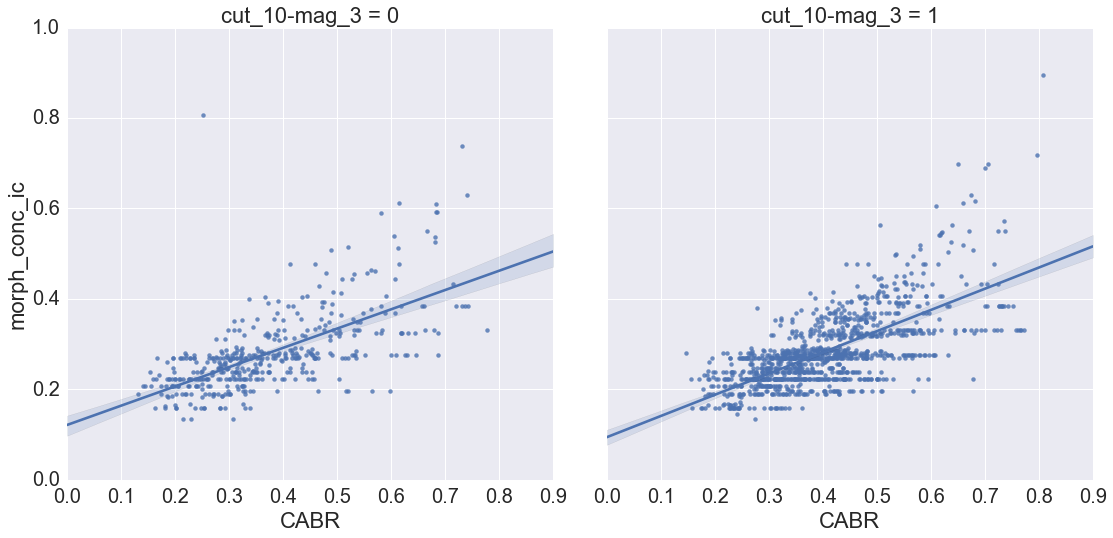

In [92]:
#fig, ax = plt.subplots(figsize=(8, 8))
sb.lmplot(x='CABR', y='morph_conc_ic', col='cut_10-mag_3', data=data, size=8, aspect=1)

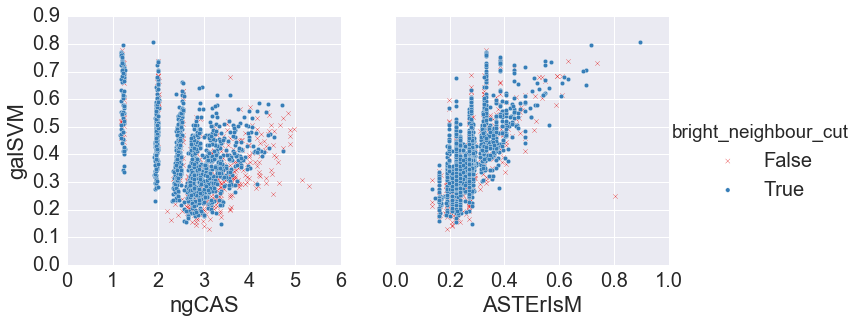

In [118]:
data['galSVM'] = data.CABR
data['ngCAS'] = data.C
data['ASTErIsM'] = data.morph_conc_ic
data['bright_neighbour_cut'] = data['cut_10-mag_3'] == 1

#sb.pairplot(data, x_vars=["C", 'morph_conc_ic'], y_vars=["CABR"], hue='cut_10-mag_3', 
sb.pairplot(data, x_vars=['ngCAS', 'ASTErIsM'], y_vars=['galSVM'], hue='bright_neighbour_cut', 
            size=5, aspect=1, markers=["x", "o"], palette="Set1")
#            hue_order=[True, False])
# plt.tight_layout()
# plt.savefig('Test_concentration.png')

In [109]:
data.bright_neighbour_cut.sum()

1131

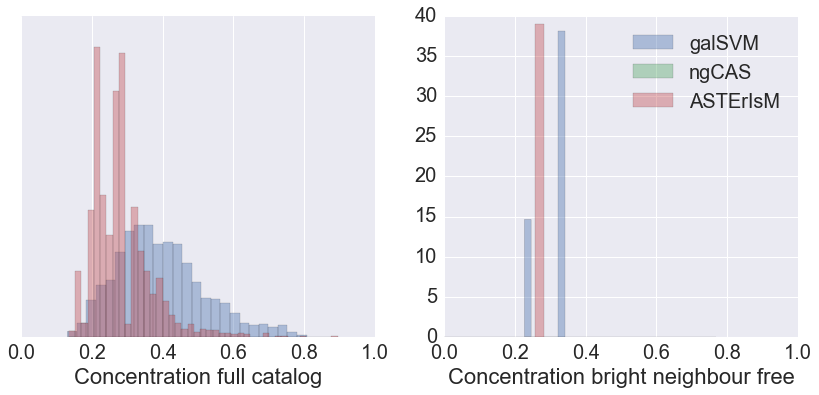

In [70]:
plot_histograms_list(allparams_plot, suffix='_concentration')a

### Violin plots w.r.t radius AND B/T

In [42]:
def plot_violin_bt_radius(parameters, par1, par2, suffix=''):
    fig, axes = plt.subplots(5, 3, figsize=(20, 25))
    for idx, ax in enumerate(axes.flat):
        param = parameters[idx]
        sb.violinplot(par1, param, par2, data=data, ax=ax, palette='Set1')
    fig.tight_layout()
    if suffix:
        fig.savefig('all_morpho_violin%s.png' % suffix)

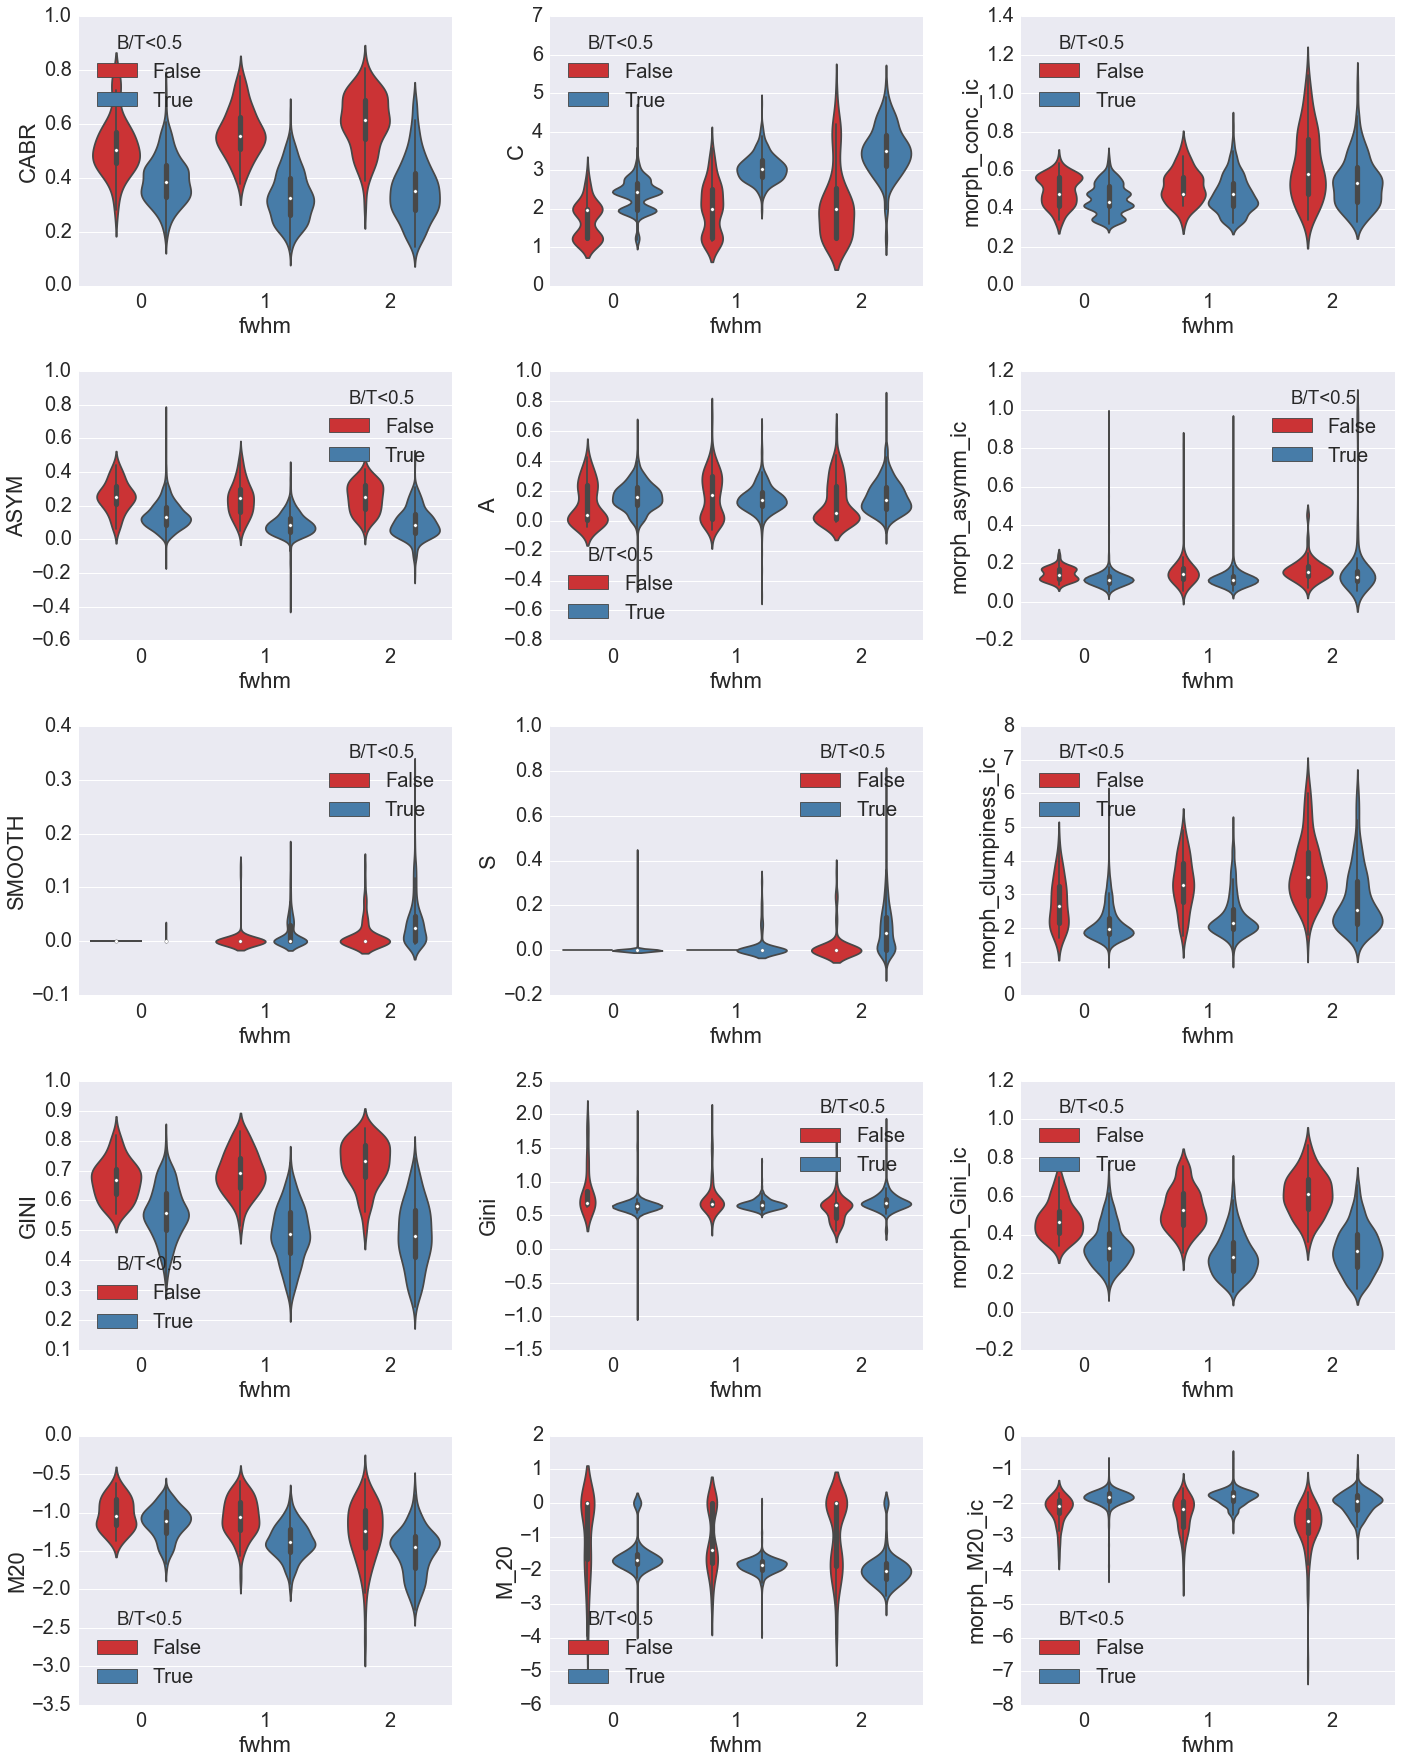

In [43]:
plot_violin_bt_radius(allparams_plot, 'fwhm', 'B/T<0.5', suffix='_bt_radius')

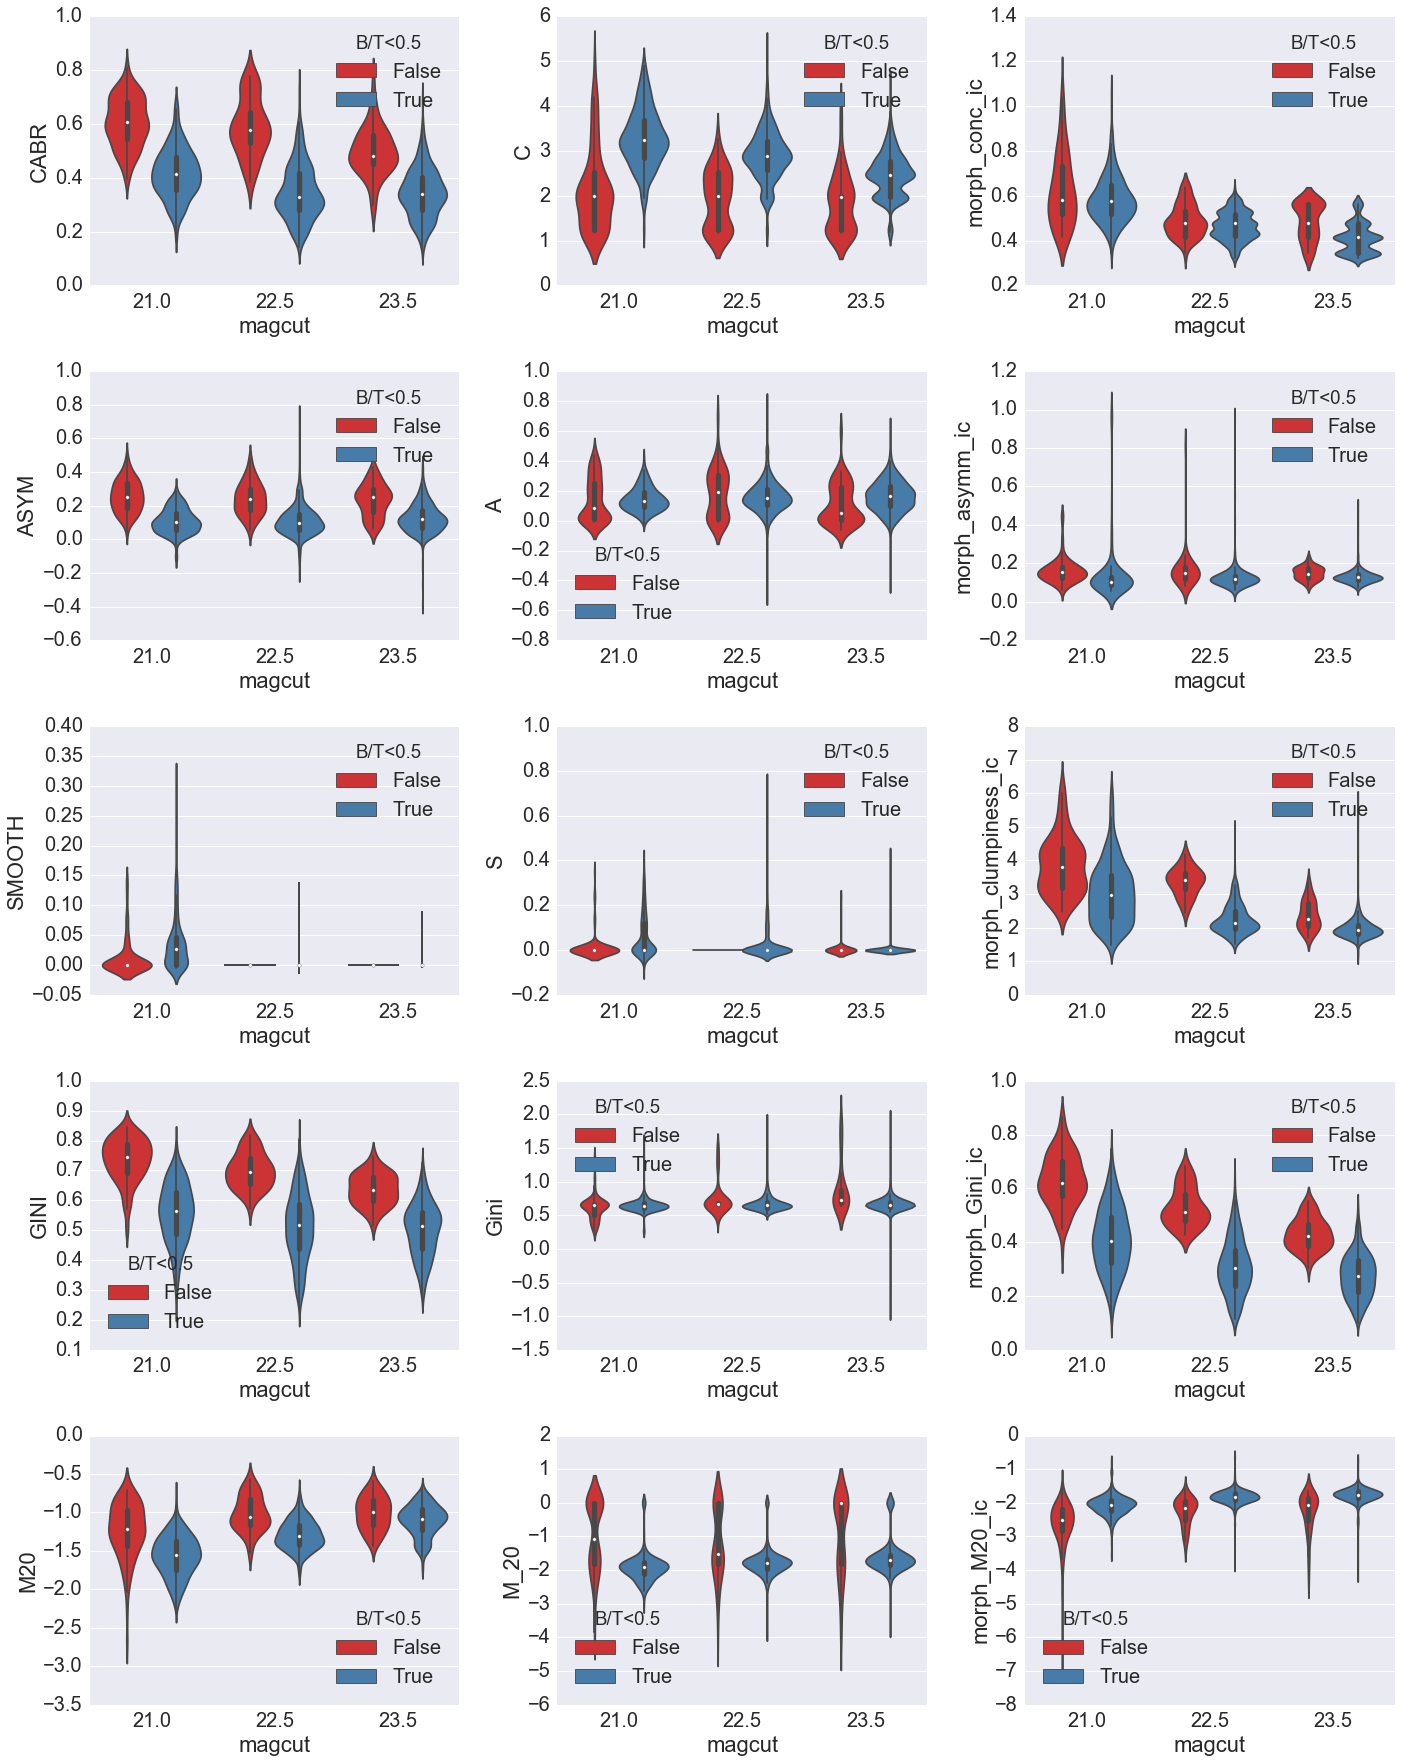

In [44]:
plot_violin_bt_radius(allparams_plot, 'magcut', 'B/T<0.5', suffix='_bt_mag')

---

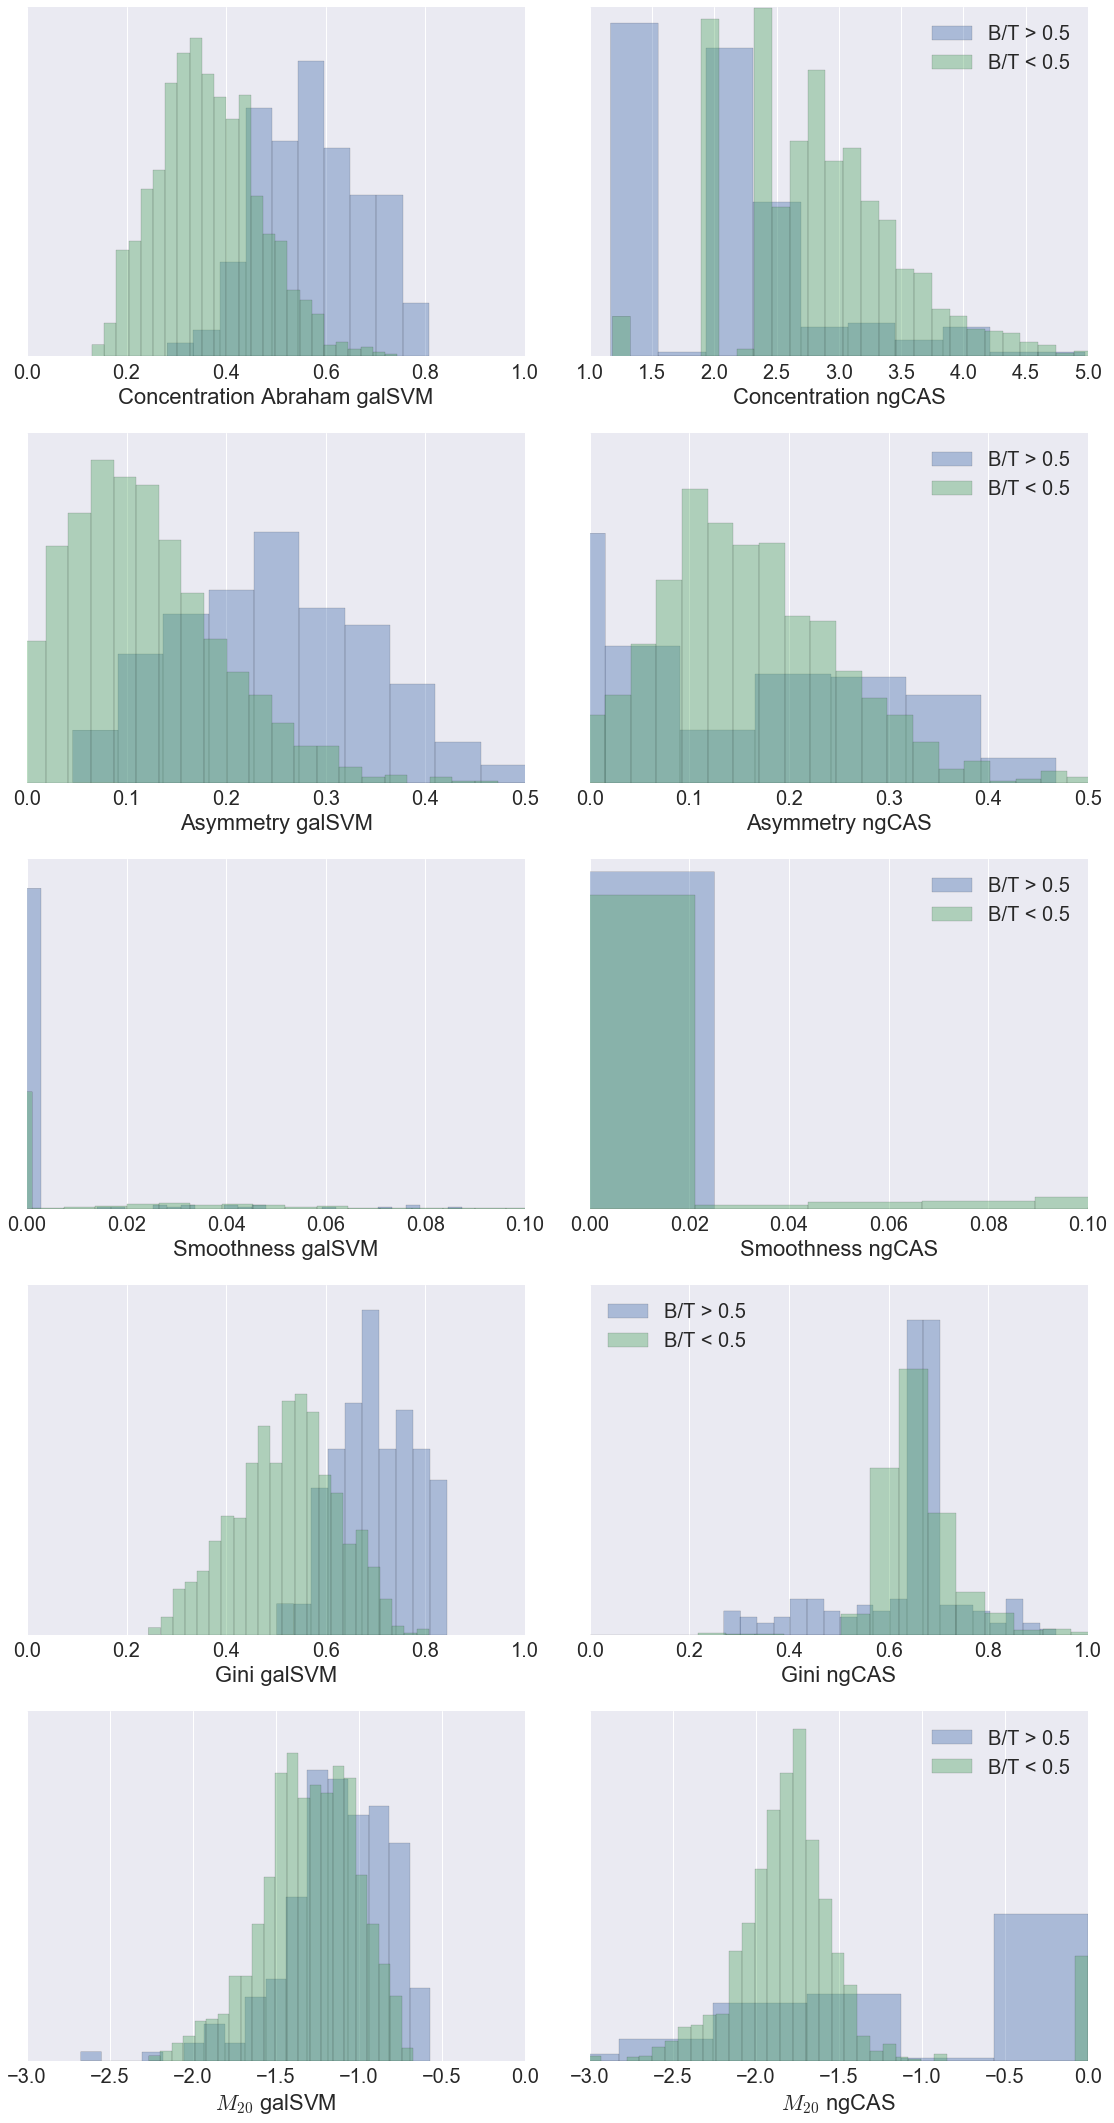

In [45]:
plot_histograms_bt_list(params_plot, [early_type, late_type], suffix='_noisy')

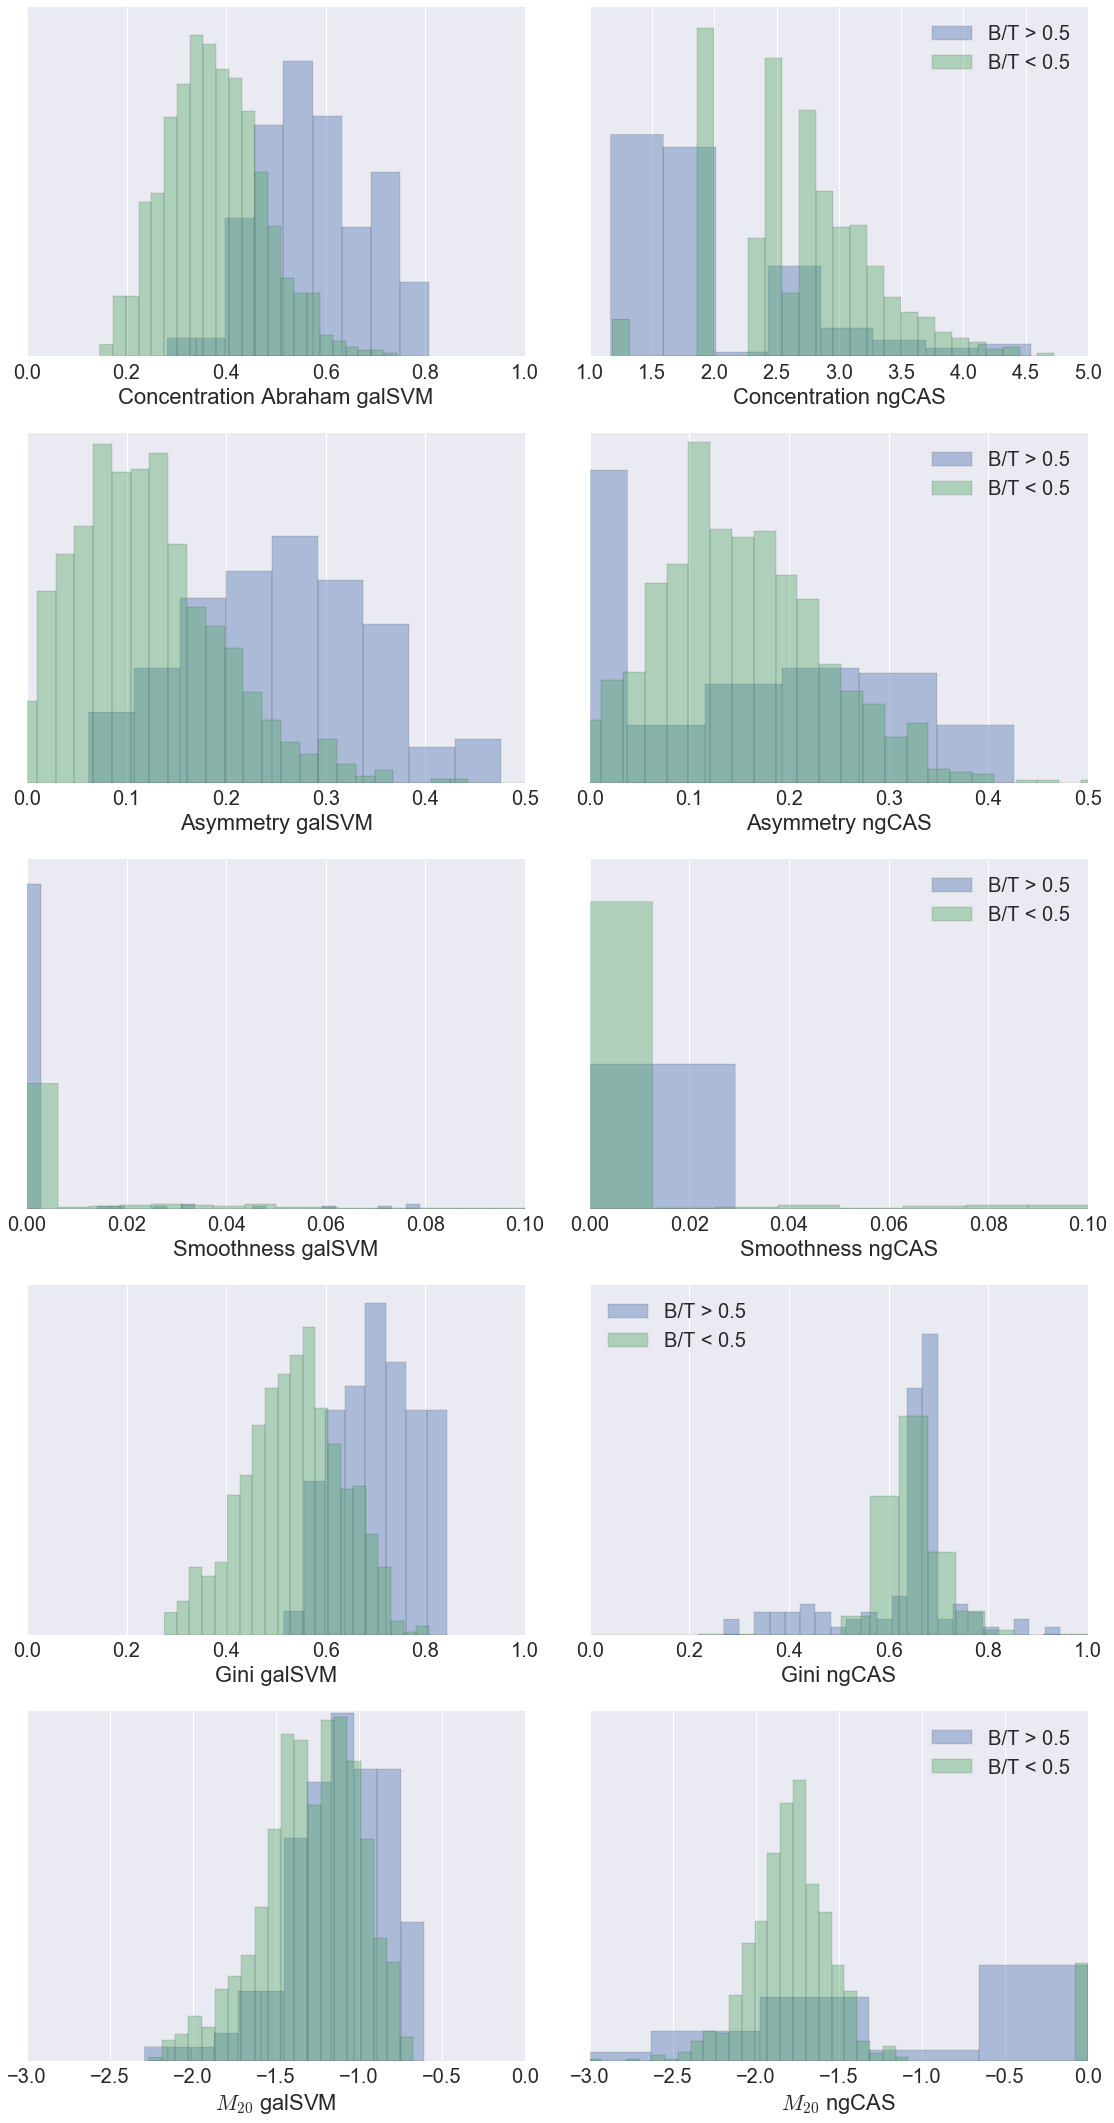

In [46]:
plot_histograms_bt_list(params_plot, [pure_early_type, pure_late_type], suffix='_noisy_pure')

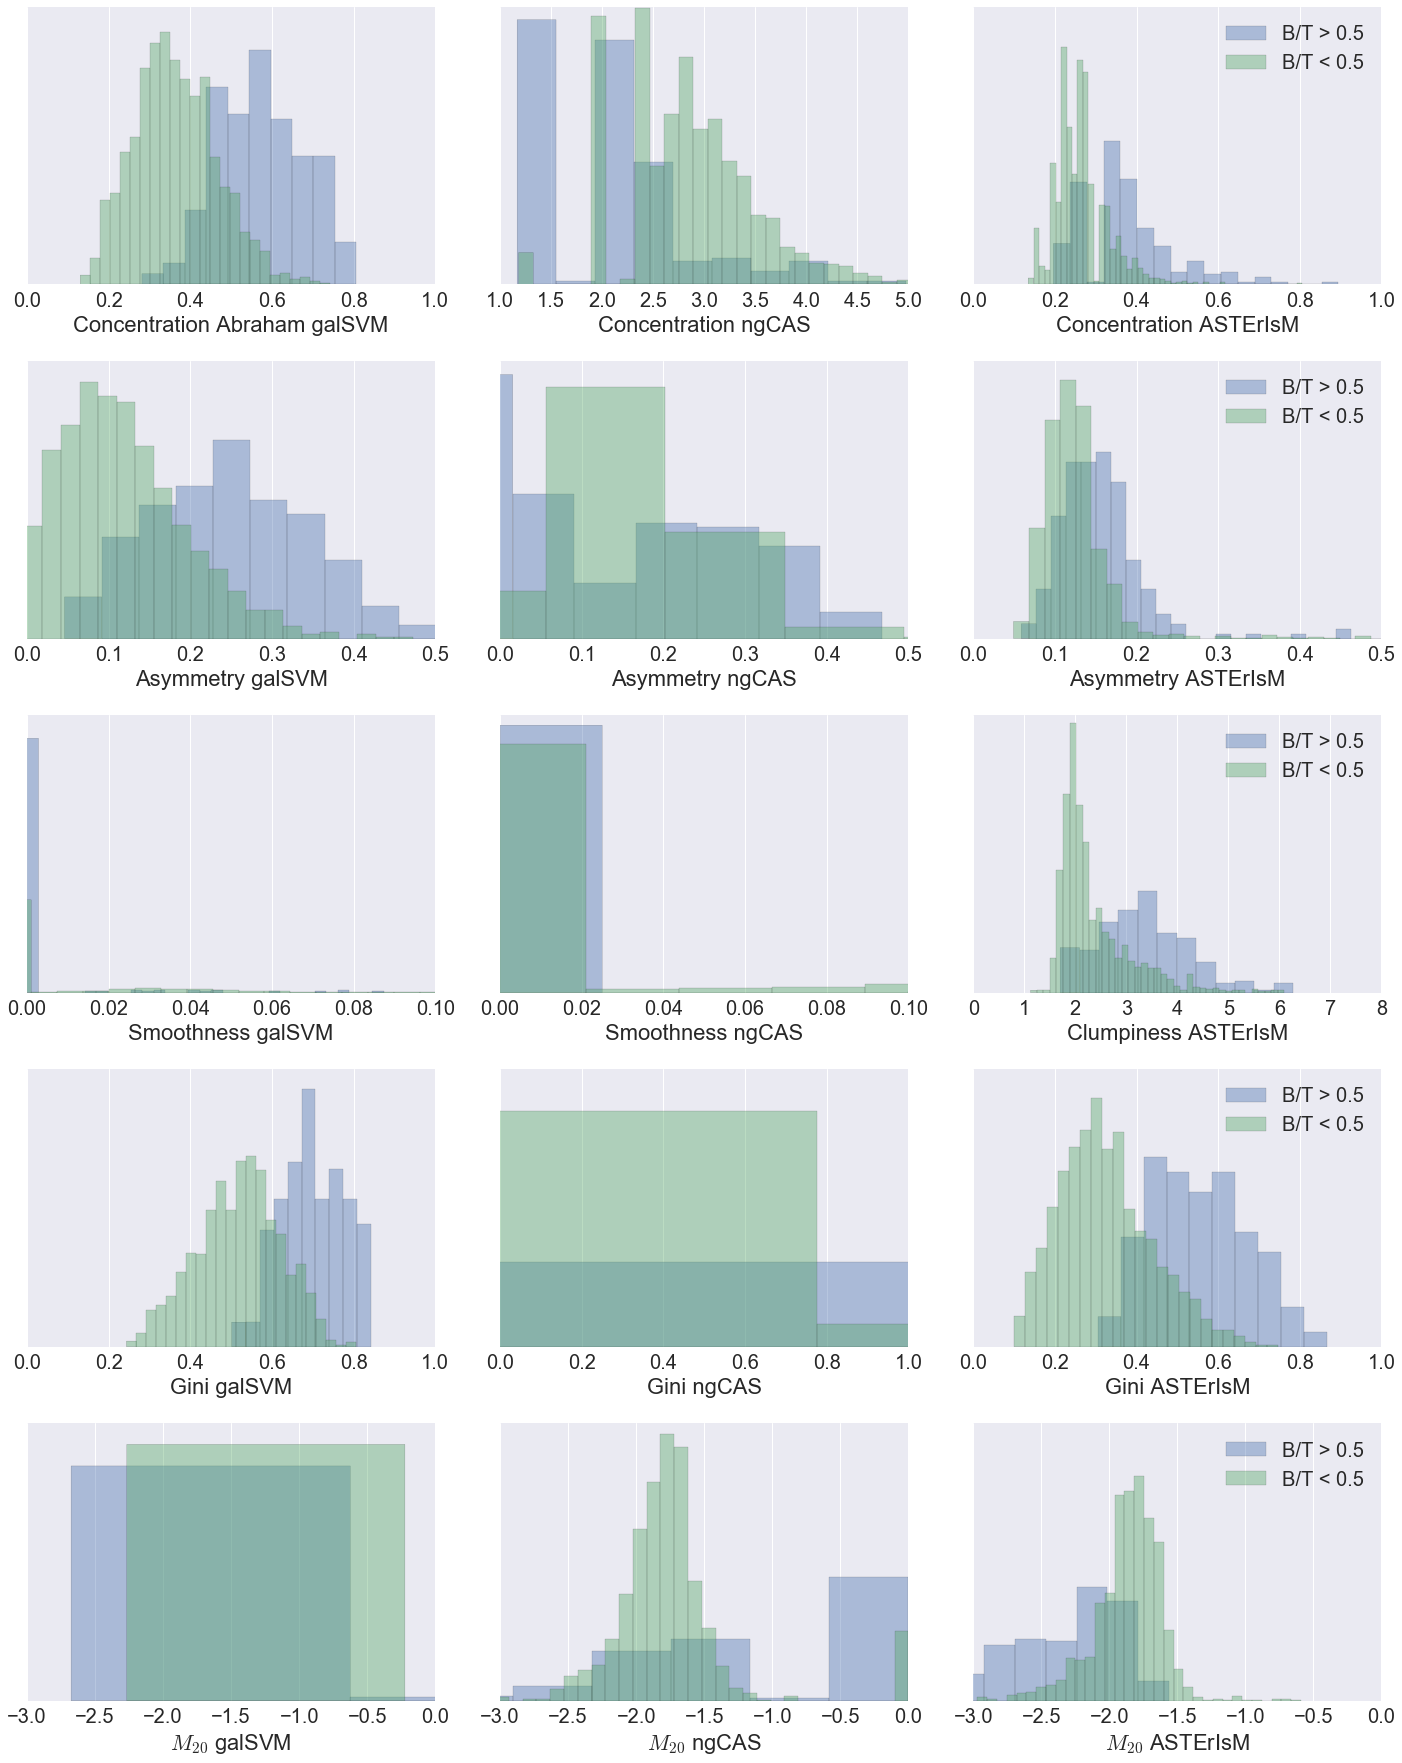

In [61]:
plot_triple_histograms_bt_list(allparams_plot, [early_type, late_type], suffix='_full_c2')

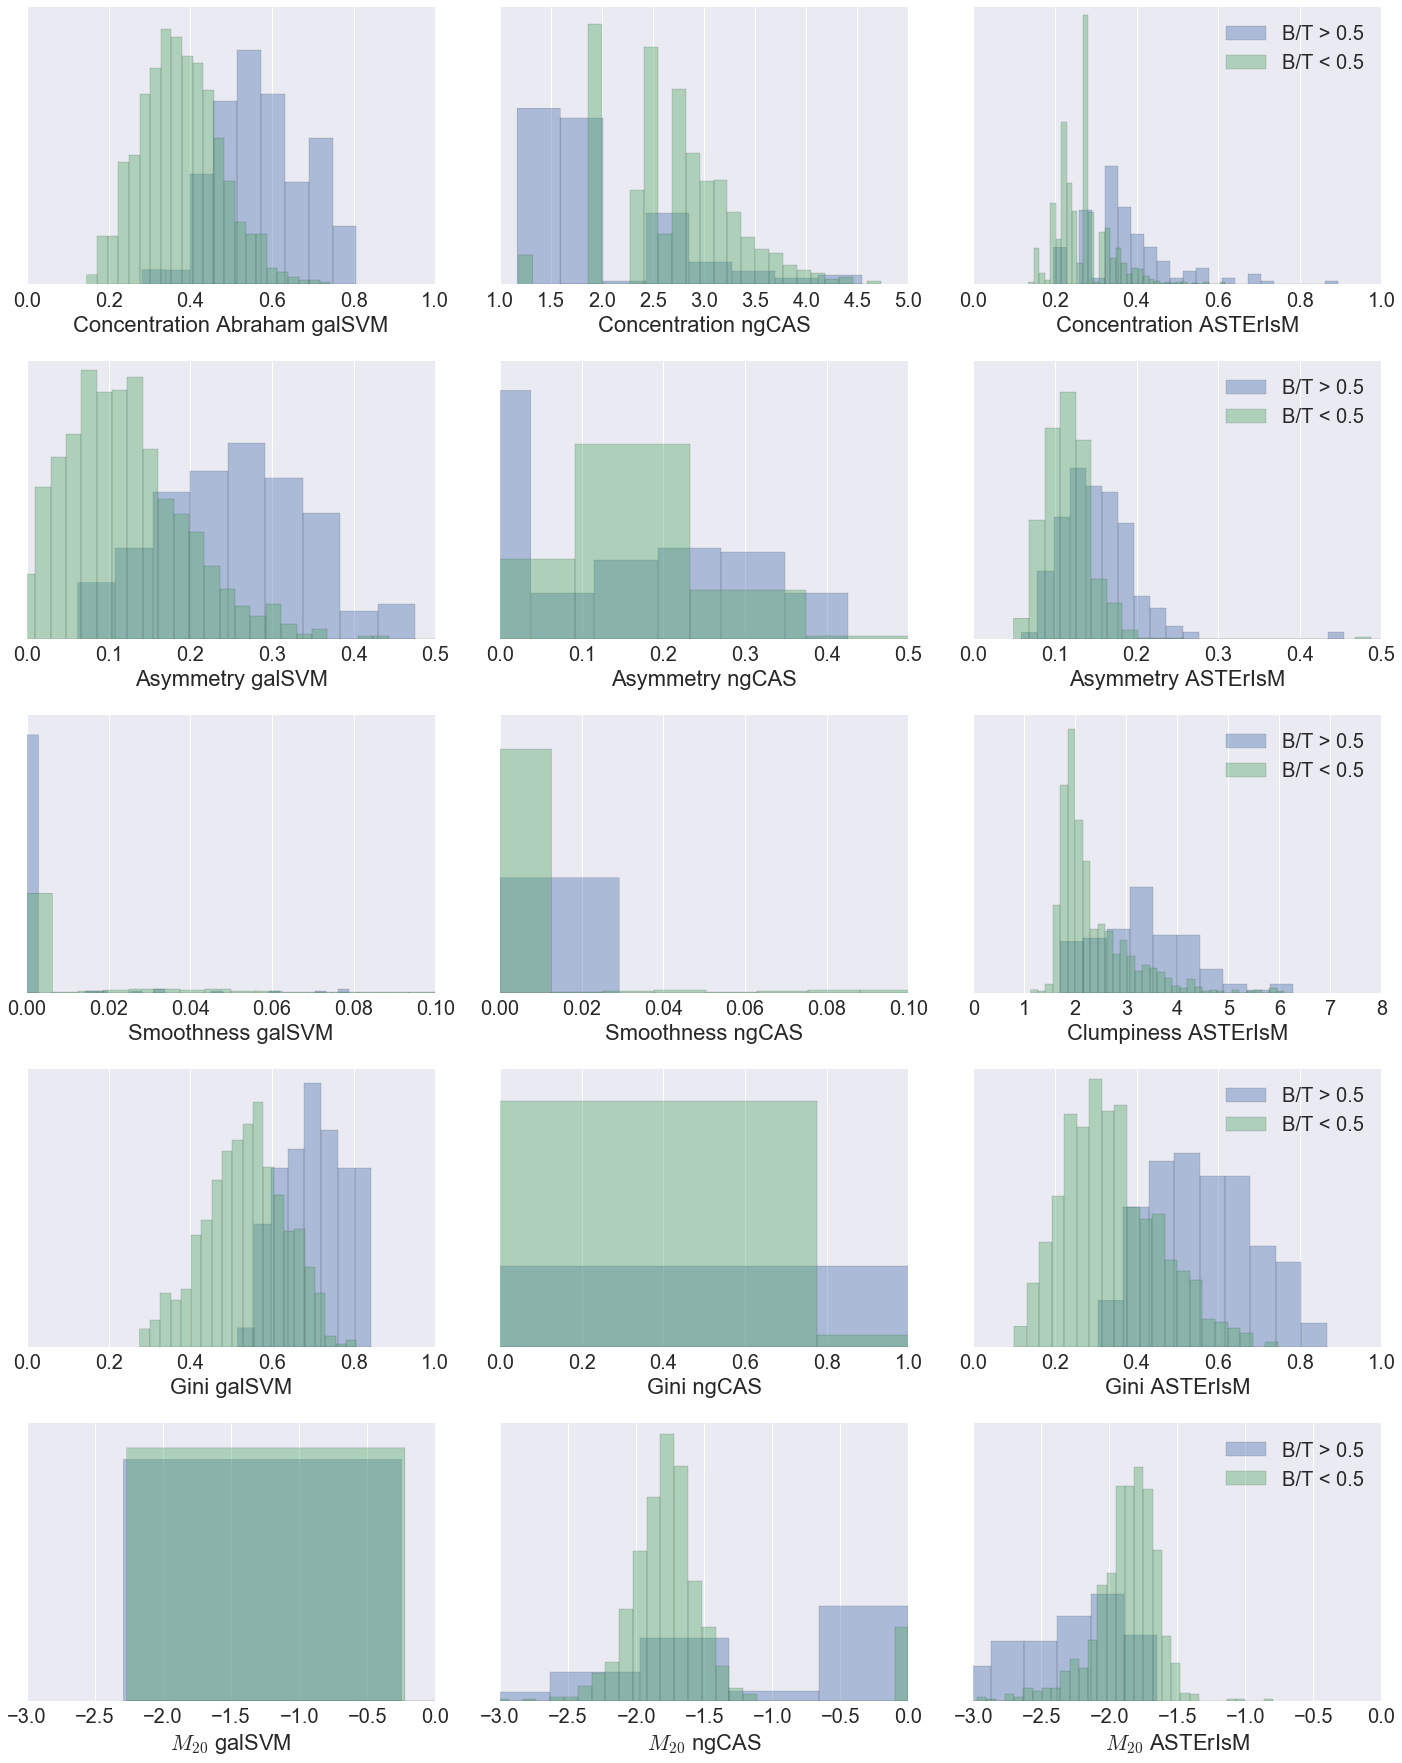

In [62]:
plot_triple_histograms_bt_list(allparams_plot, [pure_early_type, pure_late_type], suffix='_pure_c2')

## Statistics

In [16]:
ltdata = data.copy()[late_type]
etdata = data.copy()[early_type]
pltdata = data.copy()[pure_late_type]
petdata = data.copy()[pure_early_type]

In [17]:
print("Parameter", "Late Type", "Early Type", "Sigma", sep="\t\t")
for p in params_galsvm:
    string = "{0:.2f} +/- {1:.2f}"
    mean1, std1 = ltdata[p].mean(), ltdata[p].std()
    mean2, std2 = etdata[p].mean(), etdata[p].std()
    sig = abs(mean1 - mean2) / std1
    print("{:15s}".format(p), string.format(mean1, std1), string.format(mean2, std2), "{0:.1f}".format(sig), sep="\t\t")

Parameter		Late Type		Early Type		Sigma
CABR           		0.37 +/- 0.10		0.57 +/- 0.11		2.1
ASYM           		0.12 +/- 0.08		0.25 +/- 0.10		1.6
SMOOTH         		0.01 +/- 0.03		0.01 +/- 0.02		0.2
GINI           		0.52 +/- 0.10		0.70 +/- 0.08		1.8
M20            		-1.30 +/- 0.28		-1.13 +/- 0.32		0.6


In [18]:
print("Parameter", "Late Type", "Early Type", "Sigma", sep="\t\t")
for p in params_ngcas:
    string = "{0:.2f} +/- {1:.2f}"
    mean1, std1 = ltdata[p].mean(), ltdata[p].std()
    mean2, std2 = etdata[p].mean(), etdata[p].std()
    sig = abs(mean1 - mean2) / std1
    print("{:15s}".format(p), string.format(mean1, std1), string.format(mean2, std2), "{0:.1f}".format(sig), sep="\t\t")

Parameter		Late Type		Early Type		Sigma
C              		2.85 +/- 0.65		2.00 +/- 0.78		1.3
A              		0.16 +/- 0.10		0.14 +/- 0.15		0.2
S              		0.03 +/- 0.07		0.01 +/- 0.04		0.3
Gini           		0.68 +/- 0.16		0.71 +/- 0.27		0.2
M_20           		-1.75 +/- 0.48		-1.02 +/- 1.07		1.5


In [19]:
print("Parameter", "Late Type", "Early Type", "Sigma", sep="\t\t")
for p in params_asterism:
    string = "{0:.2f} +/- {1:.2f}"
    mean1, std1 = ltdata[p].mean(), ltdata[p].std()
    mean2, std2 = etdata[p].mean(), etdata[p].std()
    sig = abs(mean1 - mean2) / std1
    print("{:17s}".format(p), string.format(mean1, std1), string.format(mean2, std2), "{0:.1f}".format(sig), sep="\t\t")

Parameter		Late Type		Early Type		Sigma
morph_conc_ic    		0.27 +/- 0.07		0.37 +/- 0.11		1.6
morph_asymm_ic   		0.13 +/- 0.09		0.16 +/- 0.07		0.3
morph_clumpiness_ic		2.36 +/- 0.72		3.35 +/- 0.91		1.4
morph_Gini_ic    		0.32 +/- 0.11		0.55 +/- 0.12		2.0
morph_M20_ic     		-1.87 +/- 0.29		-2.45 +/- 0.63		2.0


In [20]:
print("Parameter", "Late Type", "Early Type", "Sigma", sep="\t\t")
for p in params_galsvm:
    string = "{0:.2f} +/- {1:.2f}"
    mean1, std1 = pltdata[p].mean(), pltdata[p].std()
    mean2, std2 = petdata[p].mean(), petdata[p].std()
    sig = abs(mean1 - mean2) / std1
    print("{:15s}".format(p), string.format(mean1, std1), string.format(mean2, std2), "{0:.1f}".format(sig), sep="\t\t")

Parameter		Late Type		Early Type		Sigma
CABR           		0.38 +/- 0.10		0.58 +/- 0.11		2.0
ASYM           		0.12 +/- 0.08		0.25 +/- 0.09		1.7
SMOOTH         		0.01 +/- 0.03		0.01 +/- 0.02		0.2
GINI           		0.54 +/- 0.10		0.71 +/- 0.08		1.7
M20            		-1.29 +/- 0.29		-1.13 +/- 0.31		0.5


In [21]:
print("Parameter", "Late Type", "Early Type", "Sigma", sep="\t\t")
for p in params_ngcas:
    string = "{0:.2f} +/- {1:.2f}"
    mean1, std1 = pltdata[p].mean(), pltdata[p].std()
    mean2, std2 = petdata[p].mean(), petdata[p].std()
    sig = abs(mean1 - mean2) / std1
    print("{:15s}".format(p), string.format(mean1, std1), string.format(mean2, std2), "{0:.1f}".format(sig), sep="\t\t")

Parameter		Late Type		Early Type		Sigma
C              		2.71 +/- 0.59		1.95 +/- 0.74		1.3
A              		0.15 +/- 0.09		0.14 +/- 0.14		0.1
S              		0.02 +/- 0.05		0.01 +/- 0.04		0.2
Gini           		0.67 +/- 0.16		0.68 +/- 0.22		0.1
M_20           		-1.71 +/- 0.48		-1.05 +/- 1.07		1.4


In [22]:
print("Parameter", "Late Type", "Early Type", "Sigma", sep="\t\t")
for p in params_asterism:
    string = "{0:.2f} +/- {1:.2f}"
    mean1, std1 = pltdata[p].mean(), pltdata[p].std()
    mean2, std2 = petdata[p].mean(), petdata[p].std()
    sig = abs(mean1 - mean2) / std1
    print("{:17s}".format(p), string.format(mean1, std1), string.format(mean2, std2), "{0:.1f}".format(sig), sep="\t\t")

Parameter		Late Type		Early Type		Sigma
morph_conc_ic    		0.27 +/- 0.07		0.38 +/- 0.11		1.6
morph_asymm_ic   		0.12 +/- 0.08		0.15 +/- 0.05		0.3
morph_clumpiness_ic		2.33 +/- 0.70		3.33 +/- 0.93		1.4
morph_Gini_ic    		0.34 +/- 0.12		0.56 +/- 0.12		1.9
morph_M20_ic     		-1.89 +/- 0.28		-2.42 +/- 0.63		1.9


In [17]:
data['radius bins'] = data.fwhm
data['magnitude bins'] = data.magcut
data['ngCAS concentration'] = data.C
data['ASTErIsM concentration'] = data.morph_conc_ic

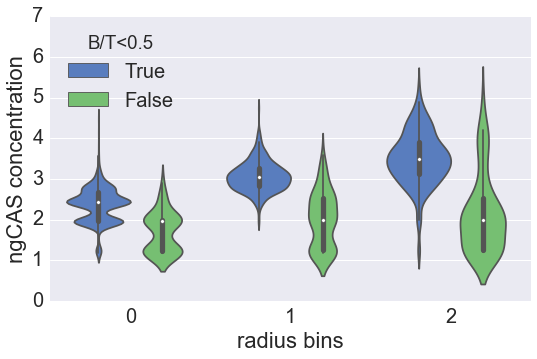

In [18]:
sb.violinplot(x='radius bins', y='ngCAS concentration', hue='B/T<0.5', data=data, palette='muted', hue_order=[True, False])
plt.tight_layout()
plt.savefig('ngCAS_concentration_vs_radius.png')

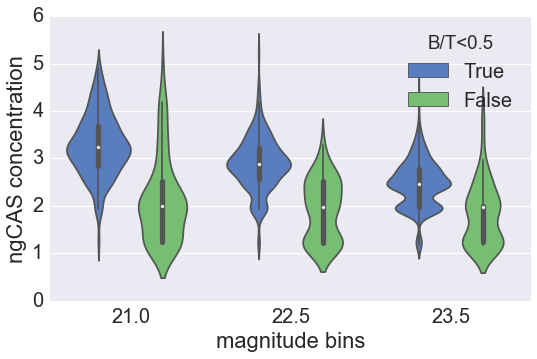

In [70]:
sb.violinplot(x='magnitude bins', y='ngCAS concentration', hue='B/T<0.5', data=data, palette='muted', hue_order=[True, False])
plt.tight_layout()
plt.savefig('ngCAS_concentration_vs_magnitude.png')

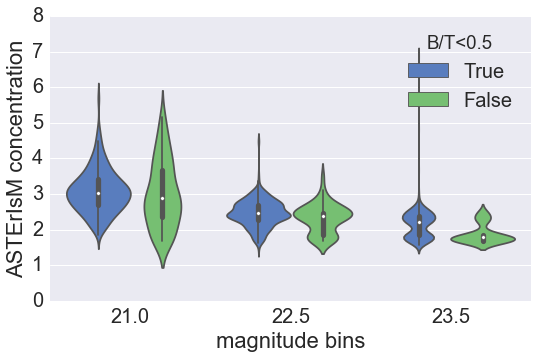

In [71]:
sb.violinplot(x='magnitude bins', y='ASTErIsM concentration', hue='B/T<0.5', data=data, palette='muted', hue_order=[True, False])
plt.tight_layout()
plt.savefig('asterism_concentration_vs_magnitude.png')

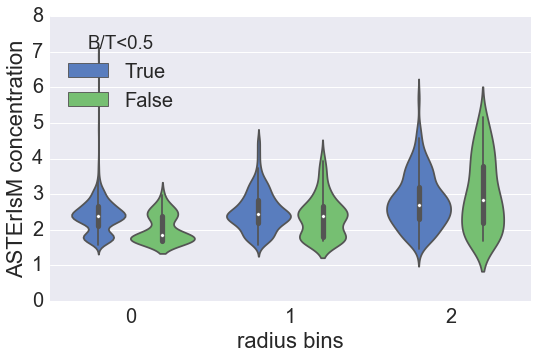

In [72]:
sb.violinplot(x='radius bins', y='ASTErIsM concentration', hue='B/T<0.5', data=data, palette='muted', hue_order=[True, False])
plt.tight_layout()
plt.savefig('asterism_concentration_vs_radius.png')

## Machine learning tests

### Classification tests

In [ ]:
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingClassifier
from sklearn.cross_validation import train_test_split

from scipy.stats import linregress

In [24]:
def get_data_target_regressor(param_list, coltarget='bt'):
    cols = param_list + [coltarget]
    datask = data[cols]
    datask = datask.dropna()
    tcol = cols.pop()
    
    return datask[cols], datask[tcol]

#### Metric I used to derive the ~90% accuracy in the first place

In [25]:
def machine_learning_efficiency(param_list, N=1000):
    skcols = param_list + ['bt']
    datask = data[skcols]
    #
    datask = datask.dropna()
    #
    maskbt = datask.bt > 0.5
    skcols.pop()
    datask = datask[skcols]
    
    perc = 0
    for _ in range(N):
        rf = RandomForestClassifier(n_jobs=-1, verbose=0)
        # rf = GradientBoostingClassifier(n_estimators=1000)
        X_train, X_test, y_train, y_test = train_test_split(datask, maskbt, test_size=0.3)
        rf.fit(X_train, y_train)

        y_predict = rf.predict(X_test)
        positive = y_predict == y_test
        true_positive = positive.sum() / y_test.size
        
        perc += true_positive
#     print("Test size %d" % y_test.size, 
#           "True positives: %f" % (true_positive))

    
    
    return perc / N

#### Enhanced metrics

In [97]:
def classification_metrics(params):
    X, target = get_data_target_regressor(params)
    y = target > 0.5

    rf = RandomForestClassifier(n_jobs=-1, verbose=0)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)
    y_predict = rf.fit(X_train, y_train).predict(X_test)

    print(classification_report(y_true=y_test, y_pred=y_predict))
    cm = confusion_matrix(y_true=y_test, y_pred=y_predict)
    ncm = cm.astype(float) / cm.sum(axis=1)[:, None]
    print("Confusion matrix:\n%s" % cm)
    print("Normalised confusion matrix:\n%s" % ncm )
    print("Precision score:\n%s" % precision_score(y_true=y_test, y_pred=y_predict))
    print("Accuracy score:\n%s" % accuracy_score(y_true=y_test, y_pred=y_predict))

In [122]:
def classification_metrics_avg(params, N):
    X, target = get_data_target_regressor(params)
    y = target > 0.5
    
    res = dict(ncm=np.zeros((2, 2)), pre=0, acc=0)
#     for _ in tnrange(N):
    for _ in range(N):

        rf = RandomForestClassifier(n_jobs=-1, verbose=0)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)
        y_predict = rf.fit(X_train, y_train).predict(X_test)


        cm = confusion_matrix(y_true=y_test, y_pred=y_predict)
        ncm = cm.astype(float) / cm.sum(axis=1)[:, None]
        res['ncm'] += ncm
        res['pre'] += precision_score(y_true=y_test, y_pred=y_predict)
        res['acc'] += accuracy_score(y_true=y_test, y_pred=y_predict)
    print("Normalised confusion matrix:\n%s" % (res['ncm'] / N))
    print("Precision score:\n%s" % (res['pre'] / N))
    print("Accuracy score:\n%s" % (res['acc'] / N))

#### Single classification realization

In [101]:
classification_metrics(params_galsvm)

             precision    recall  f1-score   support

      False       0.93      0.96      0.94       639
       True       0.66      0.47      0.55        93

avg / total       0.89      0.90      0.89       732

Confusion matrix:
[[616  23]
 [ 49  44]]
Normalised confusion matrix:
[[ 0.96  0.04]
 [ 0.53  0.47]]
Precision score:
0.65671641791
Accuracy score:
0.901639344262


In [102]:
classification_metrics(params_asterism)

             precision    recall  f1-score   support

      False       0.94      0.96      0.95       677
       True       0.69      0.62      0.65       106

avg / total       0.91      0.91      0.91       783

Confusion matrix:
[[647  30]
 [ 40  66]]
Normalised confusion matrix:
[[ 0.96  0.04]
 [ 0.38  0.62]]
Precision score:
0.6875
Accuracy score:
0.910600255428


In [103]:
classification_metrics(params_ngcas)

             precision    recall  f1-score   support

      False       0.94      0.96      0.95       665
       True       0.67      0.53      0.59        91

avg / total       0.90      0.91      0.91       756

Confusion matrix:
[[641  24]
 [ 43  48]]
Normalised confusion matrix:
[[ 0.96  0.04]
 [ 0.47  0.53]]
Precision score:
0.666666666667
Accuracy score:
0.911375661376


#### Averaged score on 100 realizations

In [125]:
print("GALSVM")
classification_metrics_avg(params_galsvm, 100)
print("NGCAS")
classification_metrics_avg(params_ngcas, 100)
print("ASTERISM")
classification_metrics_avg(params_asterism, 100)

GALSVM
Normalised confusion matrix:
[[ 0.97  0.03]
 [ 0.47  0.53]]
Precision score:
0.709261545414
Accuracy score:
0.909330601093
NGCAS
Normalised confusion matrix:
[[ 0.98  0.02]
 [ 0.44  0.56]]
Precision score:
0.777987315995
Accuracy score:
0.922235449735
ASTERISM
Normalised confusion matrix:
[[ 0.97  0.03]
 [ 0.43  0.57]]
Precision score:
0.735951192869
Accuracy score:
0.909540229885


### Regression tests

In [83]:
def machine_learning_regressor(data, target, seed=None, reg=False):
    X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.3)
    
    rf = RandomForestRegressor(n_jobs=2, random_state=seed)
    rf.fit(X_train, y_train)
    
    y_predict = rf.predict(X_test)
    if reg is True:
        theta = linregress(y_test, y_predict)
        return y_test, y_predict, theta
    
    return y_test, y_predict

In [82]:
from sklearn.metrics import *
from sklearn.model_selection import KFold, cross_val_score, permutation_test_score

In [42]:
seed = 42
datask, target = get_data_target_regressor(params_galsvm)

In [54]:
X_train, X_test, y_train, y_test = train_test_split(datask, target, test_size=0.3)    
rf = RandomForestRegressor(n_jobs=2)
# rf.fit(X_train, y_train).score(X_test, y_test)
rf.fit(X_train, y_train)
y_predict = rf.predict(X_test)


print("explained variance : ", 
      explained_variance_score(y_true=y_test, y_pred=y_predict))
print("r2_score : ",
      r2_score(y_true=y_test, y_pred=y_predict))

explained variance :  0.55569310439
r2_score :  0.553640031394


In [48]:
rf = RandomForestRegressor(n_jobs=2, random_state=seed)
k_fold = KFold()
cross_val_score(rf, datask, target, cv=k_fold, n_jobs=-1)

array([ 0.26681924,  0.36971005,  0.23185219])

In [ ]:
k_fold = KFold

In [41]:
def plot_bt(x, y, theta=None):
    plt.figure(figsize=(8,8))
    plt.plot([0,1], [0,1], 'k-', alpha=0.4)
    plt.plot(x, y, 'bo', alpha=0.5)
    plt.xlabel('B/T true')
    plt.ylabel('B/T estimated')
    if theta:
        x = np.linspace(0, 1)
        plt.plot(x, theta[0] * x + theta[1], 'r:', lw=2)
        plt.text(0.05, 0.92, 'slope = {:.3f}'.format(theta[0]))
        plt.text(0.05, 0.85, 'intercept = {:.3f}'.format(theta[1]))

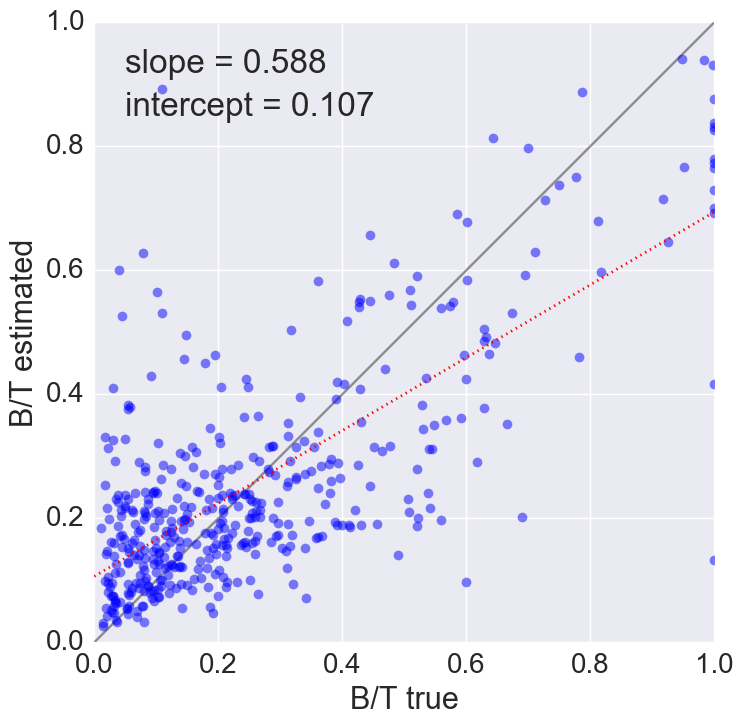

In [28]:
datask, target = get_data_target_regressor(params_galsvm)
plot_bt(*machine_learning_regressor(datask, target, reg=True))

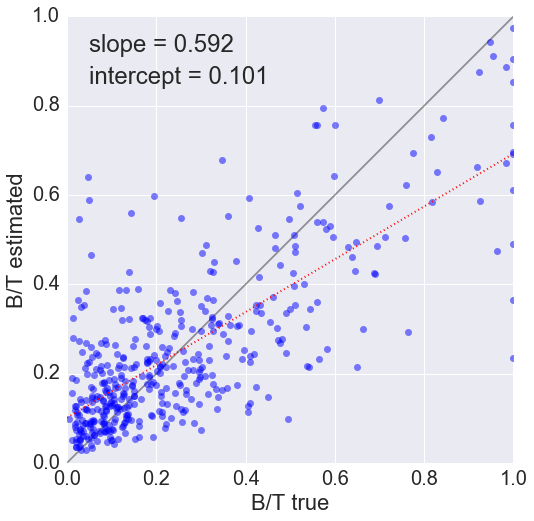

In [43]:
datask, target = get_data_target_regressor(params_galsvm)
plot_bt(*machine_learning_regressor(datask, target, reg=True))

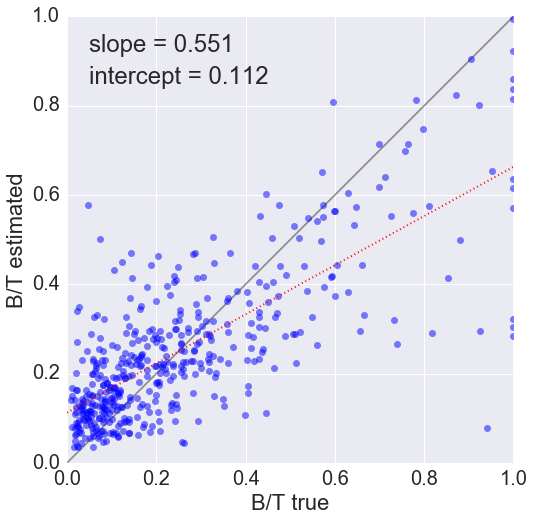

In [44]:
datask, target = get_data_target_regressor(params_ngcas)
plot_bt(*machine_learning_regressor(datask, target, reg=True))

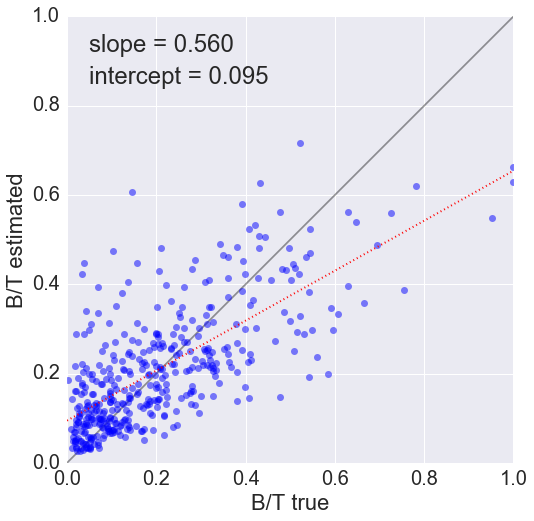

In [45]:
datask, target = get_data_target_regressor(params_asterism)
plot_bt(*machine_learning_regressor(datask, target, reg=True))

In [49]:
machine_learning_efficiency(params_galsvm)

0

In [50]:
machine_learning_efficiency(params_ngcas)

0

In [51]:
machine_learning_efficiency(params_asterism)

0